In [305]:
from tesspy import Tessellation, tessellation_functions
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from shapely import intersects
import mercantile
import matplotlib.pyplot as plt
import numpy as np
from libpysal import weights
import networkx as nx
import pyproj

In [306]:
gdf_all = gpd.read_file("files/departments/all_deps.shp")
gdf_all.crs = "epsg:4326"

In [307]:
LARGE_ZOOM_LEVEL = 13
MEDIUM_ZOOM_LEVEL = 14
SMALL_ZOOM_LEVEL = 15

In [308]:
deps = Tessellation(gdf_all)

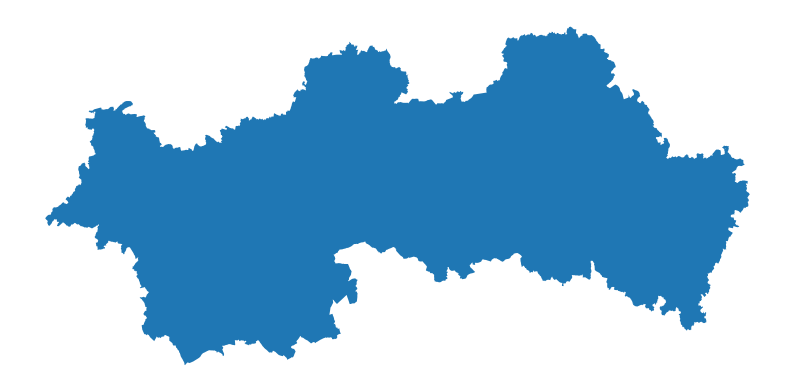

In [309]:
deps.get_polygon().plot(figsize=(10, 10)).set_axis_off()

In [310]:
deps_large = tessellation_functions.get_squares_polyfill(
    deps.area_gdf, LARGE_ZOOM_LEVEL
)

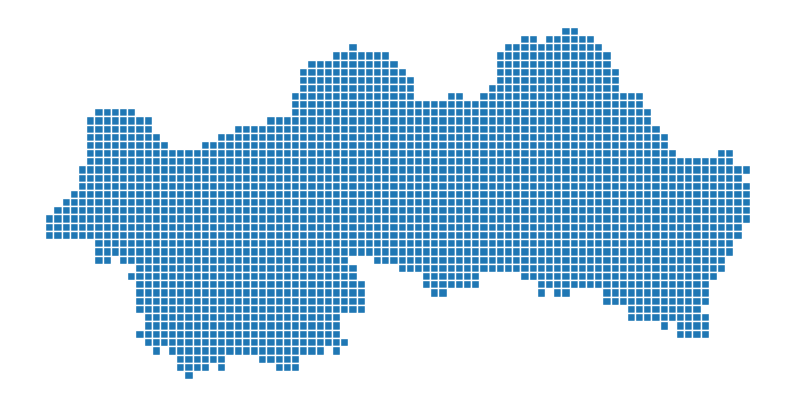

In [311]:
deps_large.plot(lw=1, edgecolor="w", figsize=(10, 10)).set_axis_off()

In [312]:
gdf_periurban = gpd.read_file("files/periurban/periurban.shp")
gdf_periurban.crs = "epsg:4326"

In [313]:
def intersects_filter(row):
    return intersects(row["geometry"], gdf_periurban["geometry"])

In [314]:
large_tiles_periurban = deps_large[deps_large.apply(intersects_filter, axis=1)[0]]

<Axes: >

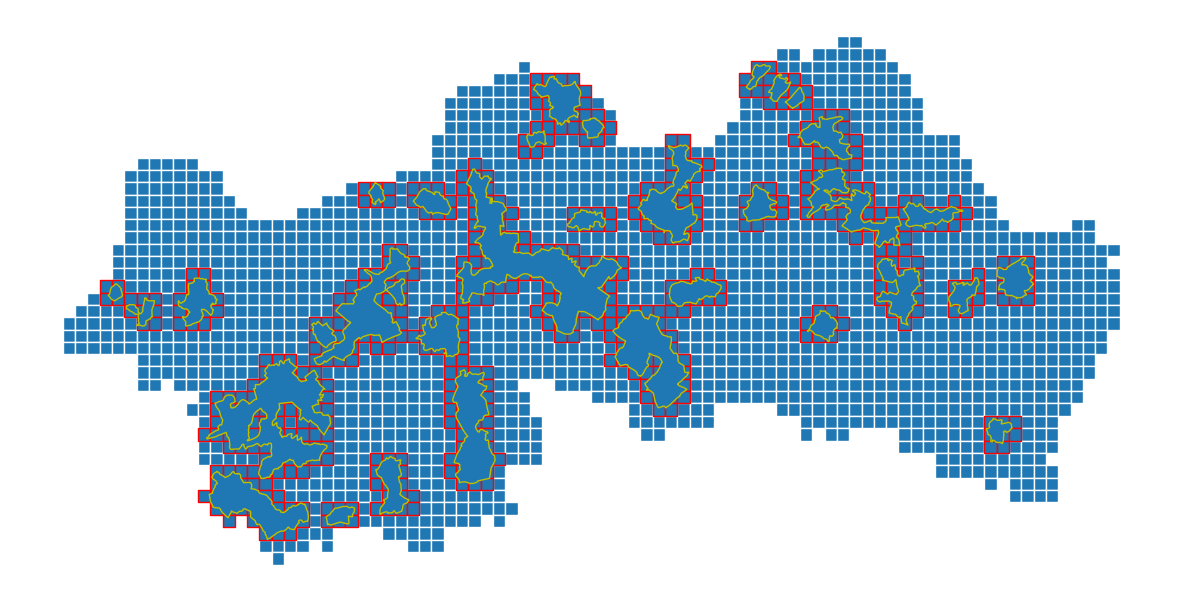

In [315]:
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
large_tiles_periurban.plot(ax=ax, lw=1, edgecolor="r", figsize=(15, 15)).set_axis_off()
gdf_periurban.plot(edgecolor="y", ax=ax)

In [316]:
deps_large["index_copy"] = deps_large.index

In [317]:
gdf_joined = gpd.overlay(gdf_periurban, deps_large, how="intersection")

In [318]:
gdf_joined.set_index("index_copy", inplace=True)

In [319]:
large_tiles_periurban["periurban_area_proportion"] = (
    gdf_joined.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
)

/tmp/ipykernel_863899/1165391927.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_joined.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [320]:
large_tiles_periurban_filtered = large_tiles_periurban[
    large_tiles_periurban["periurban_area_proportion"] >= 0.5
]

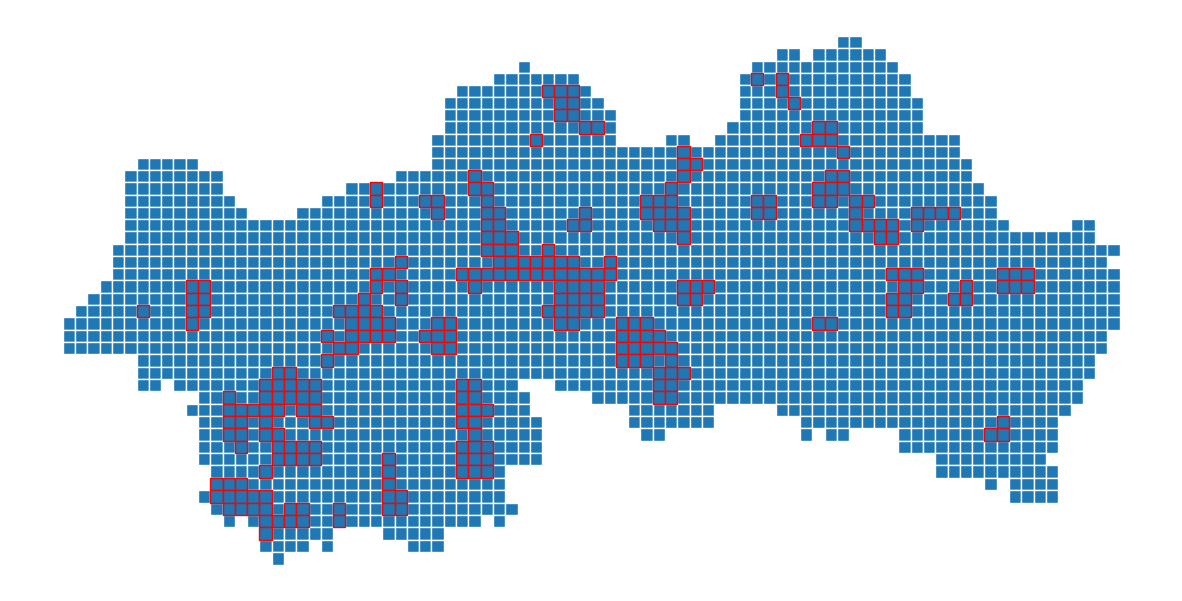

In [321]:
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
large_tiles_periurban_filtered.plot(
    ax=ax, lw=1, edgecolor="r", figsize=(15, 15)
).set_axis_off()
# gdf_periurban.plot(edgecolor="y", ax=ax)

In [322]:
def split_tile_to_zoom(tile_row, zoom_level):
    rows = []
    bbox = tile_row.geometry.bounds
    medium_tiles = mercantile.tiles(bbox[0], bbox[1], bbox[2], bbox[3], zoom_level)
    for tile in medium_tiles:
        square = box(*mercantile.bounds(tile))
        rows.append(square)
    return rows


def get_tiles_for_level(base_tiles_df, zoom_level, tile_type):
    new_rows = []
    for row in base_tiles_df.apply(
        lambda row: split_tile_to_zoom(row, zoom_level), axis=1
    ):
        new_rows.extend(row)
    new_df = pd.DataFrame(new_rows, columns=["geometry"])
    new_df["type"] = tile_type
    return gpd.GeoDataFrame(new_df, geometry="geometry", crs="epsg:4326")

In [323]:
medium_tiles = get_tiles_for_level(
    large_tiles_periurban_filtered, MEDIUM_ZOOM_LEVEL, "periurban"
)

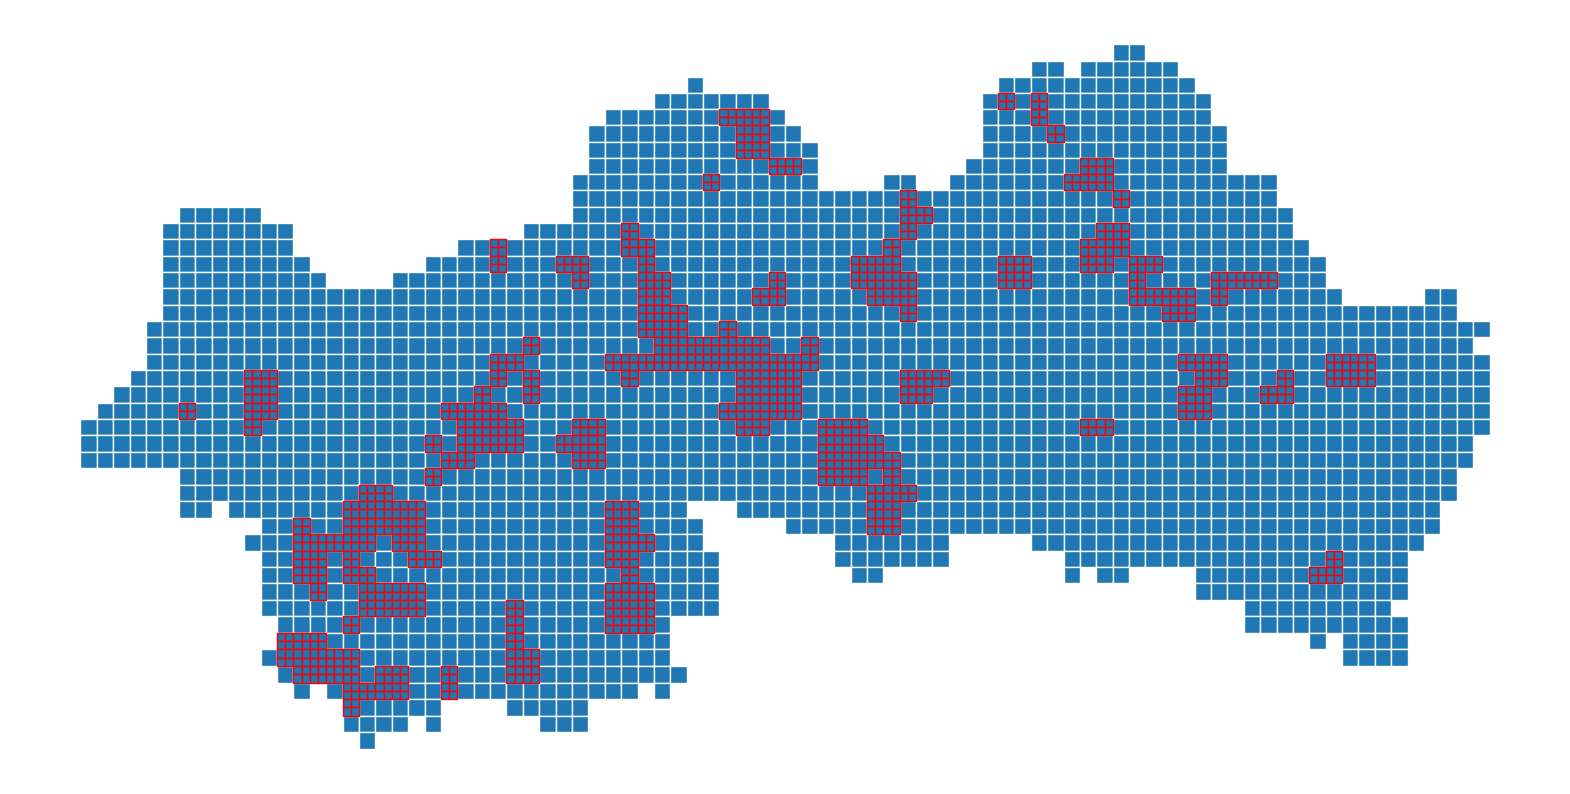

In [324]:
f, ax = plt.subplots(figsize=(20, 20))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(20, 20)).set_axis_off()
medium_tiles.plot(ax=ax, lw=1, edgecolor="r", figsize=(20, 20)).set_axis_off()
# gdf_periurban.plot(edgecolor="y", ax=ax)

In [325]:
gdf_urban = gpd.read_file("files/urban/urban.shp")
gdf_urban.crs = "epsg:4326"


def urban_intersects_filter(row):
    return intersects(row["geometry"], gdf_urban["geometry"])


large_tiles_urban = deps_large[deps_large.apply(urban_intersects_filter, axis=1)[0]]

<Axes: >

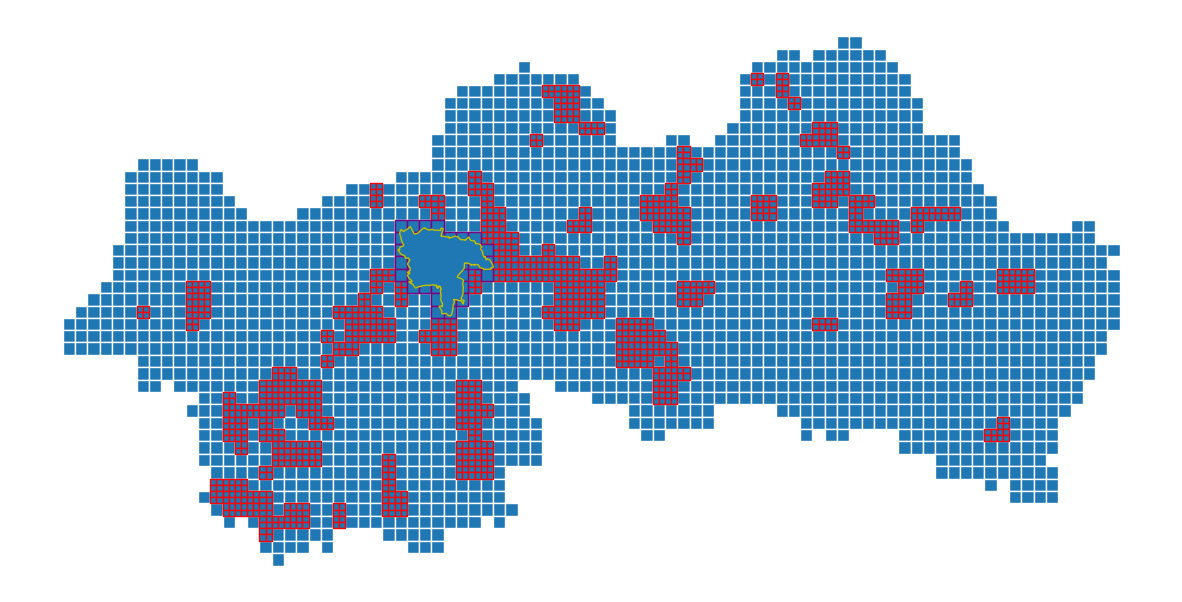

In [326]:
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
medium_tiles.plot(ax=ax, lw=1, edgecolor="r", figsize=(20, 20)).set_axis_off()
large_tiles_urban.plot(ax=ax, lw=1, edgecolor="purple", figsize=(15, 15)).set_axis_off()
gdf_urban.plot(edgecolor="y", ax=ax)

/tmp/ipykernel_863899/3217006072.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_joined_urban.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

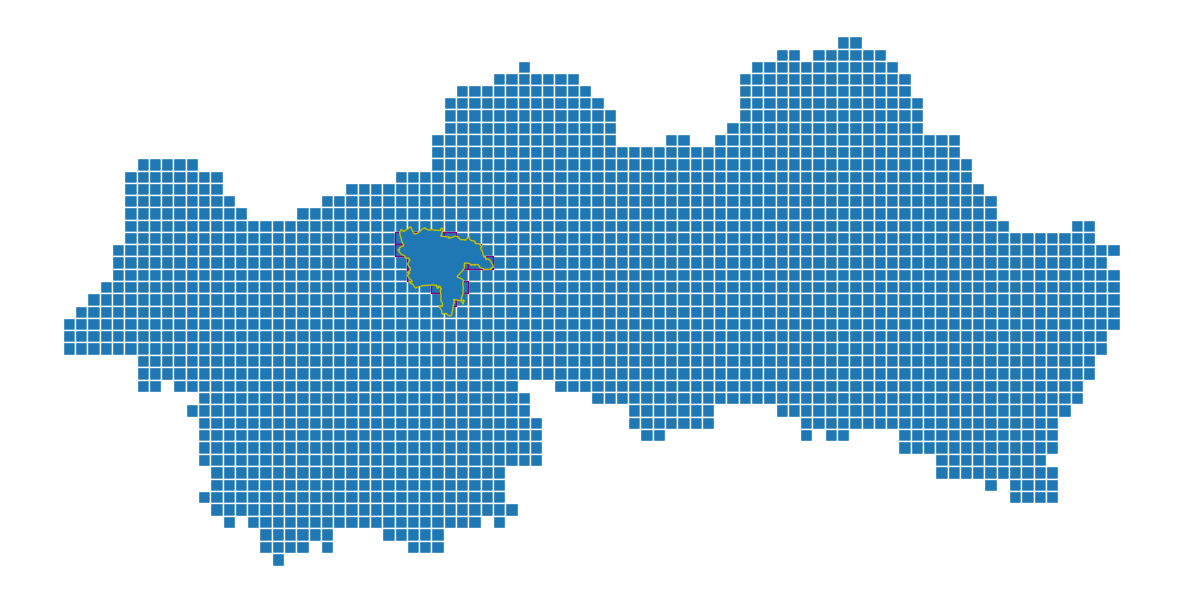

In [327]:
deps_large["index_copy"] = deps_large.index
gdf_joined_urban = gpd.overlay(gdf_urban, deps_large, how="intersection")
gdf_joined_urban.set_index("index_copy", inplace=True)
large_tiles_urban["urban_area_proportion"] = (
    gdf_joined_urban.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
)
large_tiles_urban_filtered = large_tiles_urban[
    large_tiles_urban["urban_area_proportion"] >= 0.5
]
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
large_tiles_urban_filtered.plot(
    ax=ax, lw=1, edgecolor="purple", figsize=(15, 15)
).set_axis_off()
gdf_urban.plot(edgecolor="y", ax=ax)

In [328]:
small_tiles = get_tiles_for_level(large_tiles_urban_filtered, SMALL_ZOOM_LEVEL, "urban")

<Axes: >

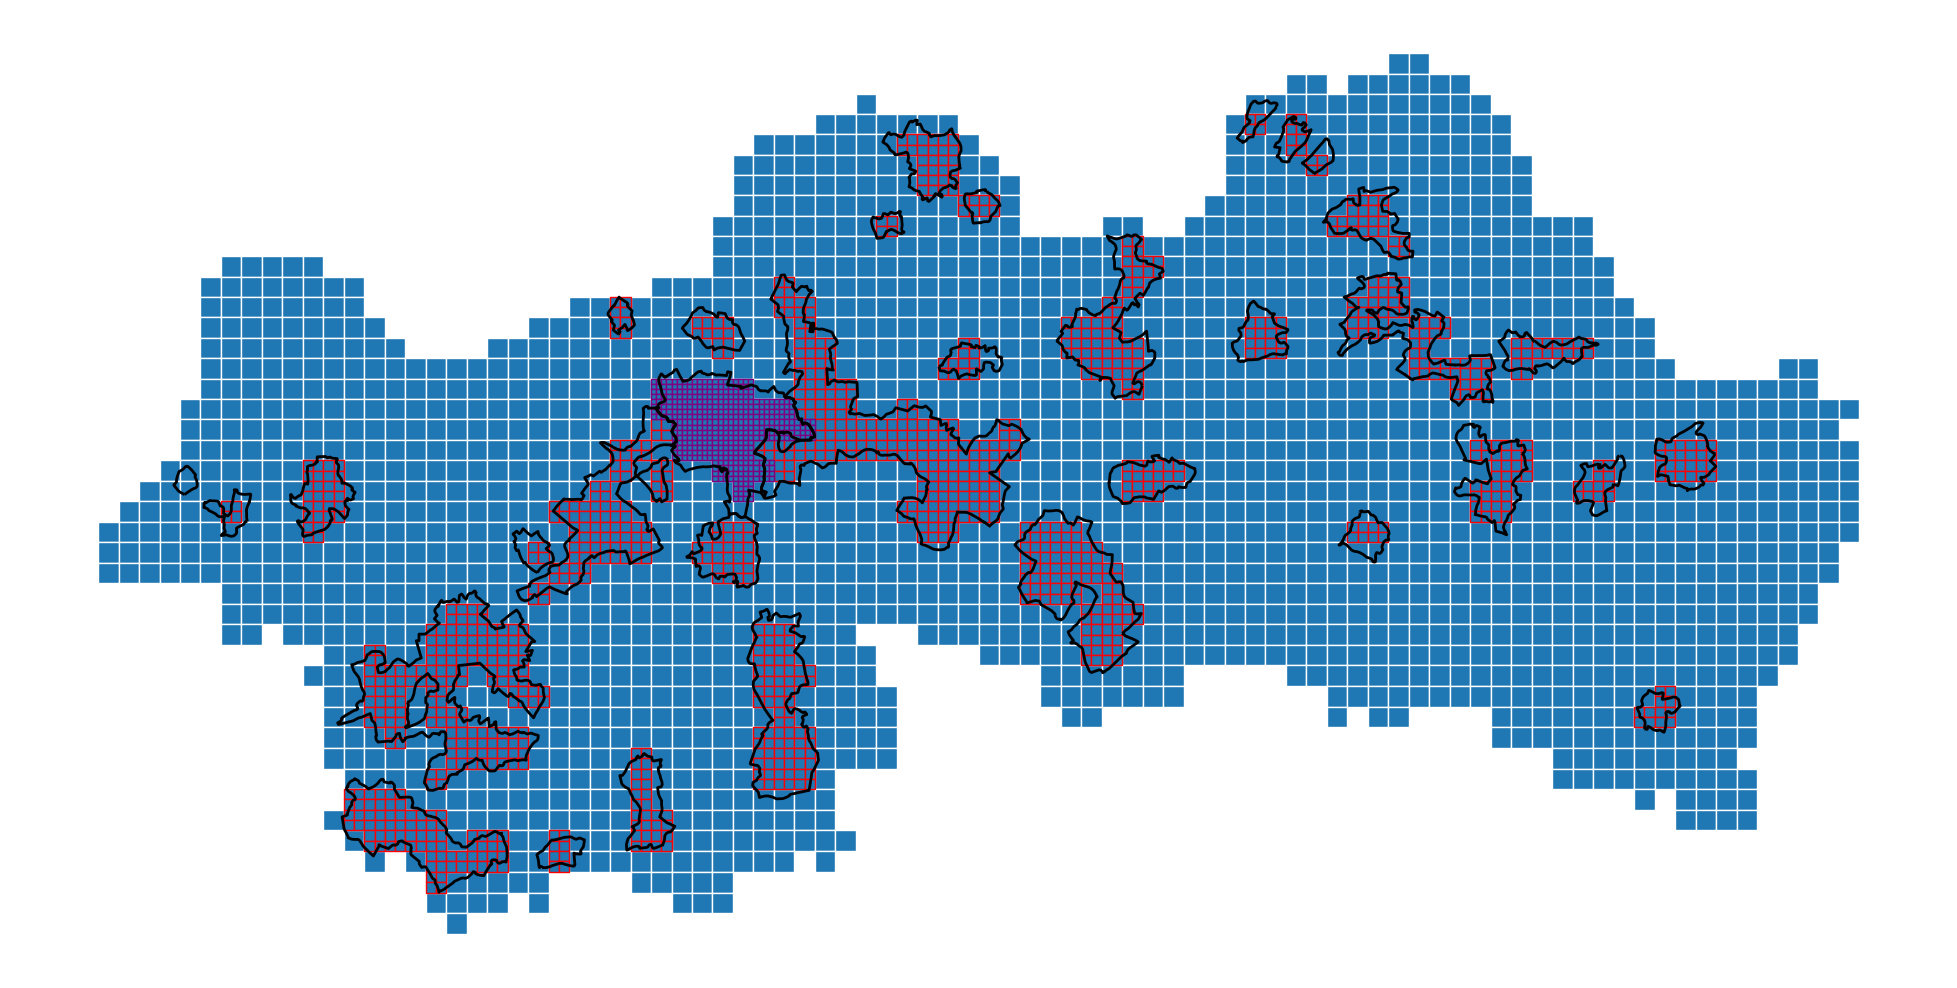

In [329]:
f, ax = plt.subplots(figsize=(25, 25))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(25, 25)).set_axis_off()
medium_tiles.plot(ax=ax, lw=1, edgecolor="r", figsize=(25, 25)).set_axis_off()
small_tiles.plot(ax=ax, lw=1, edgecolor="purple", figsize=(25, 25)).set_axis_off()
gdf_urban.plot(ax=ax, lw=2, edgecolor="black", facecolor="none")
gdf_periurban.plot(ax=ax, lw=2, edgecolor="black", facecolor="none")

## From tiles to network

In [330]:
centroids = np.column_stack((deps_large.centroid.x, deps_large.centroid.y))
queen = weights.Rook.from_dataframe(deps_large)
graph = queen.to_networkx()
positions = dict(zip(graph.nodes, centroids))

/tmp/ipykernel_863899/158546080.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.column_stack((deps_large.centroid.x, deps_large.centroid.y))
/tmp/ipykernel_863899/158546080.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Rook.from_dataframe(deps_large)


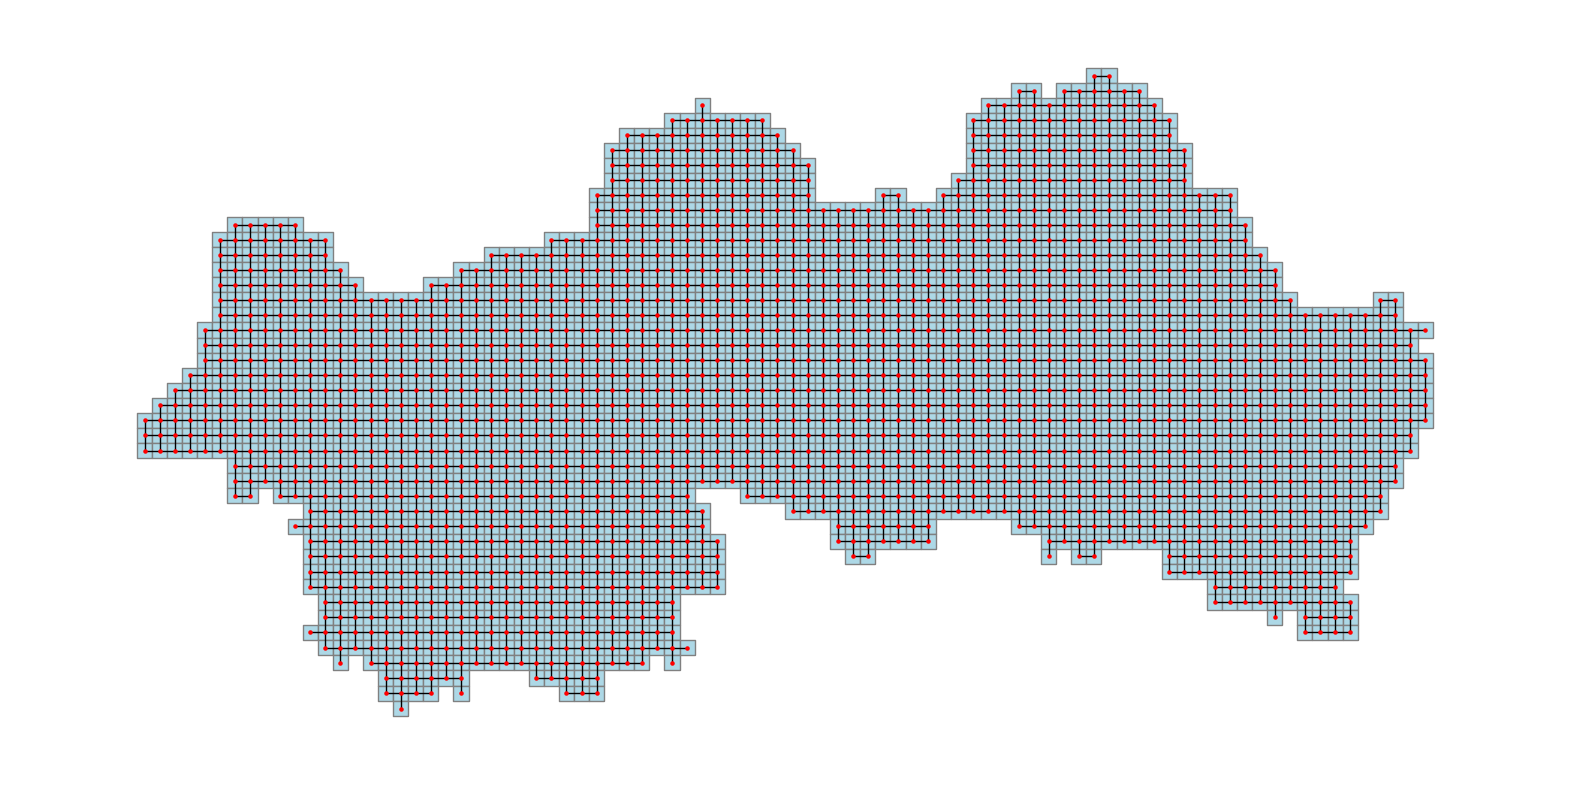

In [331]:
# plot with a nice basemap
ax = deps_large.plot(
    linewidth=1, edgecolor="grey", figsize=(20, 20), facecolor="lightblue"
)
nx.draw(graph, positions, ax=ax, node_size=5, node_color="r")
plt.show()

## Put together different-sized tiles

In [332]:
tiles_df = deps_large[["geometry"]].copy()

In [333]:
in_medium = tiles_df.index.isin(large_tiles_periurban_filtered.index)
tiles_df = tiles_df[~in_medium]

In [334]:
in_small = tiles_df.index.isin(large_tiles_urban_filtered.index)
tiles_df = tiles_df[~in_small]

<Axes: >

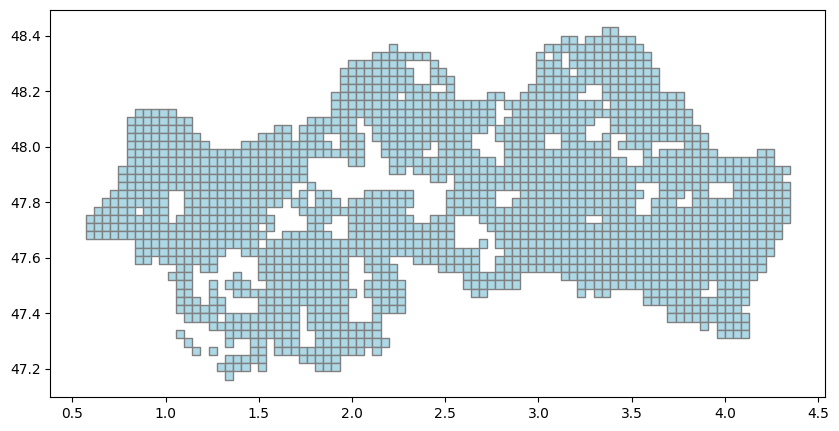

In [335]:
tiles_df.plot(linewidth=1, edgecolor="grey", figsize=(10, 10), facecolor="lightblue")

In [336]:
tiles_df["type"] = "rural"

In [337]:
tiles_df = pd.concat([tiles_df, small_tiles, medium_tiles])
tiles_df = tiles_df.reset_index(drop=True)
tiles_df["tile_id"] = tiles_df.index

In [338]:
tiles_df.shape

(3423, 3)

<Axes: >

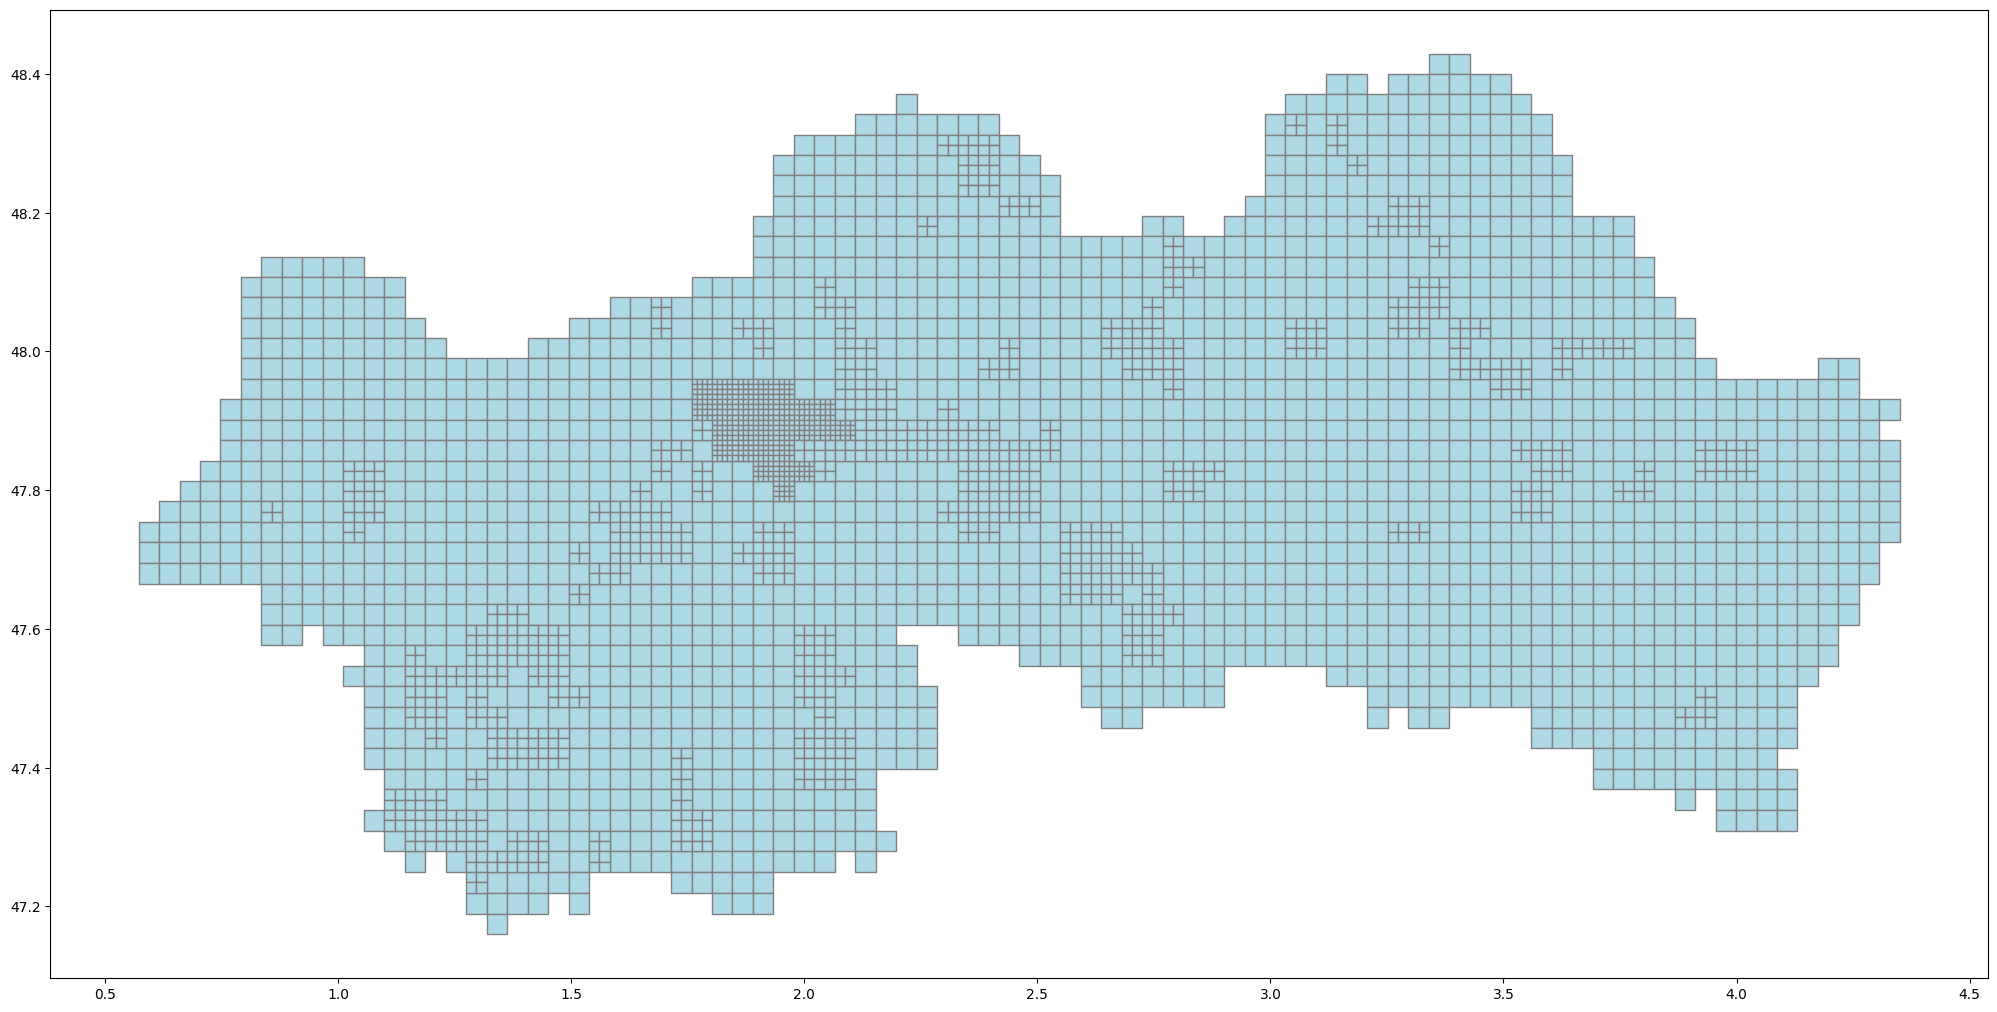

In [339]:
tiles_df.plot(linewidth=1, edgecolor="grey", figsize=(25, 25), facecolor="lightblue")

In [347]:
tiles_df["type"].value_counts()

type
rural        1807
periurban    1184
urban         432
Name: count, dtype: int64

## Measurements

In [340]:
df_measurements = pd.read_csv("files/measurements.csv", delimiter=";")

In [368]:
MIN_THRESHOLD_ALL = dict(rural=2, periurban=2, urban=1)
MIN_THRESHOLD_4G = dict(rural=3, periurban=2, urban=1)
MIN_THRESHOLD_5G = dict(rural=3, periurban=2, urban=1)

## All measurements

In [348]:
gdf_measurements_all = gpd.GeoDataFrame(
    df_measurements, geometry=gpd.points_from_xy(df_measurements.X, df_measurements.Y)
)
gdf_measurements_all.crs = "epsg:2154"  # lambert 93
gdf_measurements_all = gdf_measurements_all.to_crs("epsg:4326")

<Axes: >

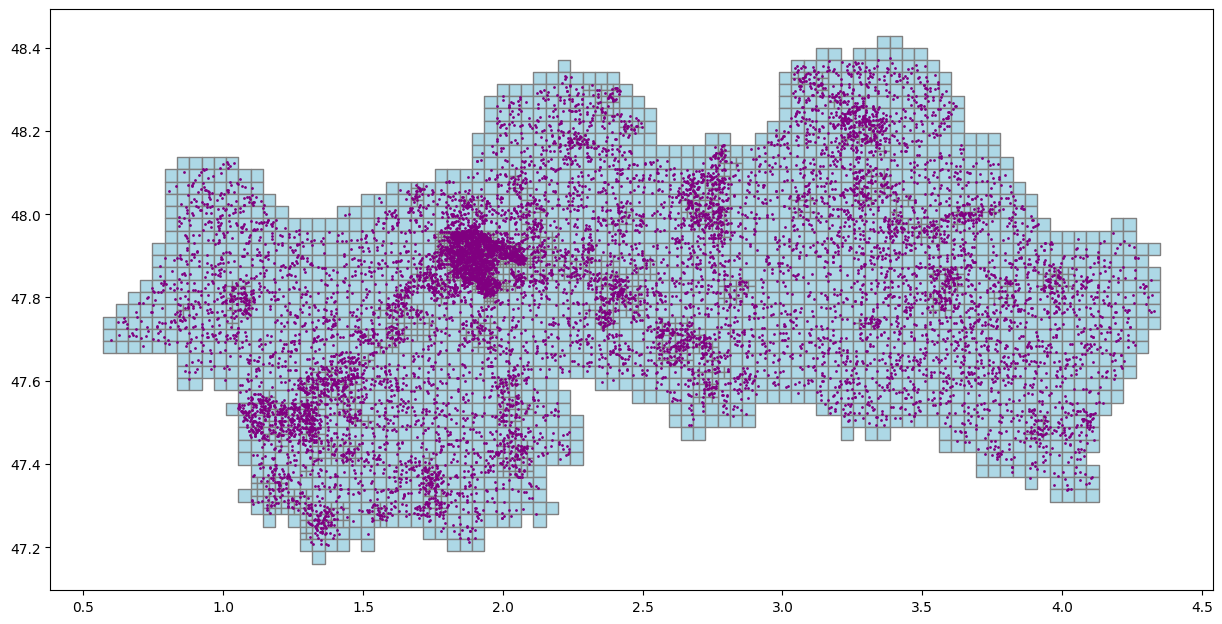

In [349]:
f, ax = plt.subplots(figsize=(15, 15))
tiles_df.plot(
    ax=ax, linewidth=1, edgecolor="grey", figsize=(15, 15), facecolor="lightblue"
)
gdf_measurements_all.plot(ax=ax, markersize=1, color="purple")

In [420]:
gdf_measurements_all.head()

,ID,X,Y,Techno,operateur,dbm,Puissance recue,geometry
0,OP1_4G_1,528480,6734006,4G,OP1,-122,Mauvaise,POINT (0.71348 47.68409)
1,OP1_4G_2,532425,6735325,4G,OP1,-114,Moyenne,POINT (0.76555 47.69697)
2,OP1_4G_3,534492,6734651,4G,OP1,-39,Bonne,POINT (0.79335 47.69143)
3,OP1_4G_4,534096,6736042,4G,OP1,-40,Bonne,POINT (0.78755 47.70385)
4,OP1_4G_5,535524,6734374,4G,OP1,-115,Moyenne,POINT (0.80720 47.68920)


In [501]:
def add_measurements_count(
    input_df,
    measurements_df,
    threshold_use,
    id_column="tile_id",
    point_count_name="points_count",
):
    base_df = input_df.copy()
    original_index = base_df.index
    if original_index.name == id_column:
        base_df = base_df.reset_index()

    gdf_sjoined = gpd.sjoin(base_df, measurements_df, how="inner")

    aggregations = {}
    aggregations["ID"] = "size"
    aggregations["dbm"] = "mean"
    aggregations["operateur"] = lambda ops: set(ops)

    gdf_tiles_measures = (
        gdf_sjoined[[id_column, "ID", "dbm", "operateur"]]
        .set_index(id_column)
        .groupby(id_column)
        .agg(aggregations)
        .rename(
            columns={
                "ID": point_count_name,
                "dbm": f"meandbm_{point_count_name}",
                "operateur": f"operators_{point_count_name}",
            }
        )
    )
    # print(gdf_tiles_measures.columns)

    # gdf_tiles_measures = (
    #     gpd.sjoin(base_df, measurements_df, how="inner")
    #     .groupby(id_column)
    #     .size()
    #     .rename(point_count_name)
    # )

    joined_df = (
        base_df.set_index(id_column)
        .join(gdf_tiles_measures, how="left")
        .fillna({
          point_count_name: 0
        })
    )

    if original_index.name != id_column:
        # Avoids duplicating polygon_id as column and index
        joined_df = joined_df.reset_index()
    joined_df = joined_df.set_index(original_index)  # Restore the original index
    joined_df[f"use_{count_col_name}"] = joined_df[point_count_name] >= joined_df[
        "type"
    ].map(lambda tile_type: threshold_use[tile_type])

    return joined_df

In [502]:
count_col_name = "total_measurements"
tiles_with_counts = add_measurements_count(
    tiles_df,
    gdf_measurements_all,
    id_column="tile_id",
    point_count_name=count_col_name,
    threshold_use=MIN_THRESHOLD_ALL,
)
tiles_with_counts.shape

(3423, 7)

In [503]:
tiles_with_counts.head()

,tile_id,geometry,type,total_measurements,meandbm_total_measurements,operators_total_measurements,use_total_measurements
0,0,"POLYGON ((0.61523 47.72454, 0.61523 47.75410, ...",rural,0.0,NaN,NaN,False
1,1,"POLYGON ((0.61523 47.69497, 0.61523 47.72454, ...",rural,1.0,-98.000000,{OP3},False
2,2,"POLYGON ((0.61523 47.66539, 0.61523 47.69497, ...",rural,0.0,NaN,NaN,False
3,3,"POLYGON ((0.65918 47.75410, 0.65918 47.78363, ...",rural,0.0,NaN,NaN,False
4,4,"POLYGON ((0.65918 47.72454, 0.65918 47.75410, ...",rural,6.0,-79.666667,"{OP2, OP3, OP4}",True


In [504]:
colors = dict(
    red=(1.0, 0.7, 0.7, 0.2),  # Pastel red with 50% opacity
    pink=(1.0, 0.8, 0.85, 0.1),  # Pastel pink with 50% opacity
    yellow=(1.0, 0.95, 0.7, 0.1),  # Pastel yellow with 50% opacity
)

def get_colormap(use):
    if use:
        return "lightblue"
    else:
        return "azure"


def get_linewidth_map(use):
    if use:
        return 1
    else:
        return 1

In [505]:
count_col_name = "total_measurements"
tiles_with_counts = add_measurements_count(
    tiles_df,
    gdf_measurements_all,
    id_column="tile_id",
    point_count_name=count_col_name,
    threshold_use=MIN_THRESHOLD_ALL,
)
tiles_with_counts.shape

(3423, 7)

<Axes: >

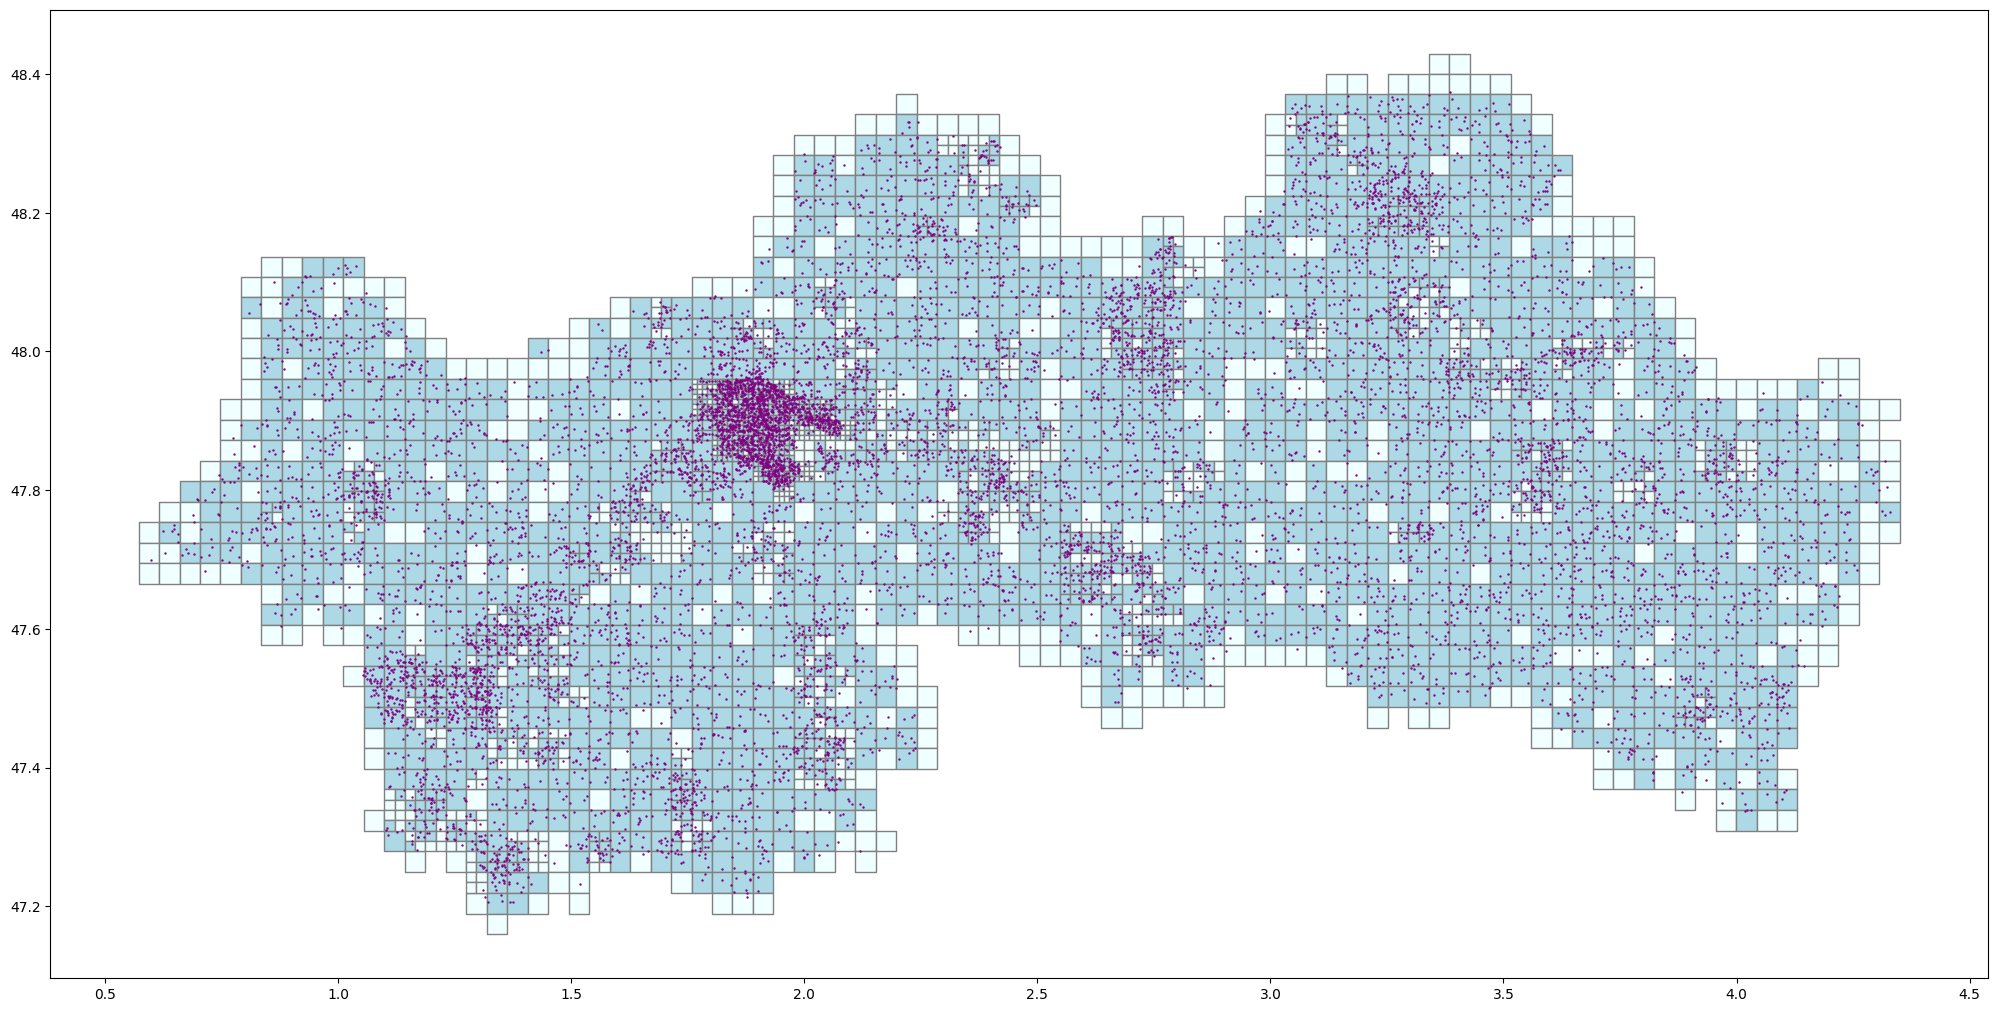

In [506]:
f, ax = plt.subplots(figsize=(25, 25))
tiles_with_counts.plot(
    ax=ax,
    linewidth=tiles_with_counts[f"use_{count_col_name}"].map(get_linewidth_map),
    edgecolor="grey",
    figsize=(25, 25),
    facecolor=tiles_with_counts[f"use_{count_col_name}"].map(get_colormap),
)
gdf_measurements_all.plot(ax=ax, markersize=0.5, color="purple")

## Split 4G and 5G

In [507]:
gdf_measurements_4g = (
    gdf_measurements_all[gdf_measurements_all["Techno"] == "4G"].copy().reset_index()
)
gdf_measurements_5g = (
    gdf_measurements_all[gdf_measurements_all["Techno"] == "5G"].copy().reset_index()
)

In [508]:
count_col_name = "4g_measurements"
tiles_with_counts = add_measurements_count(
    tiles_with_counts,
    gdf_measurements_4g,
    id_column="tile_id",
    point_count_name=count_col_name,
    threshold_use=MIN_THRESHOLD_4G,
)
tiles_with_counts.shape

(3423, 11)

<Axes: >

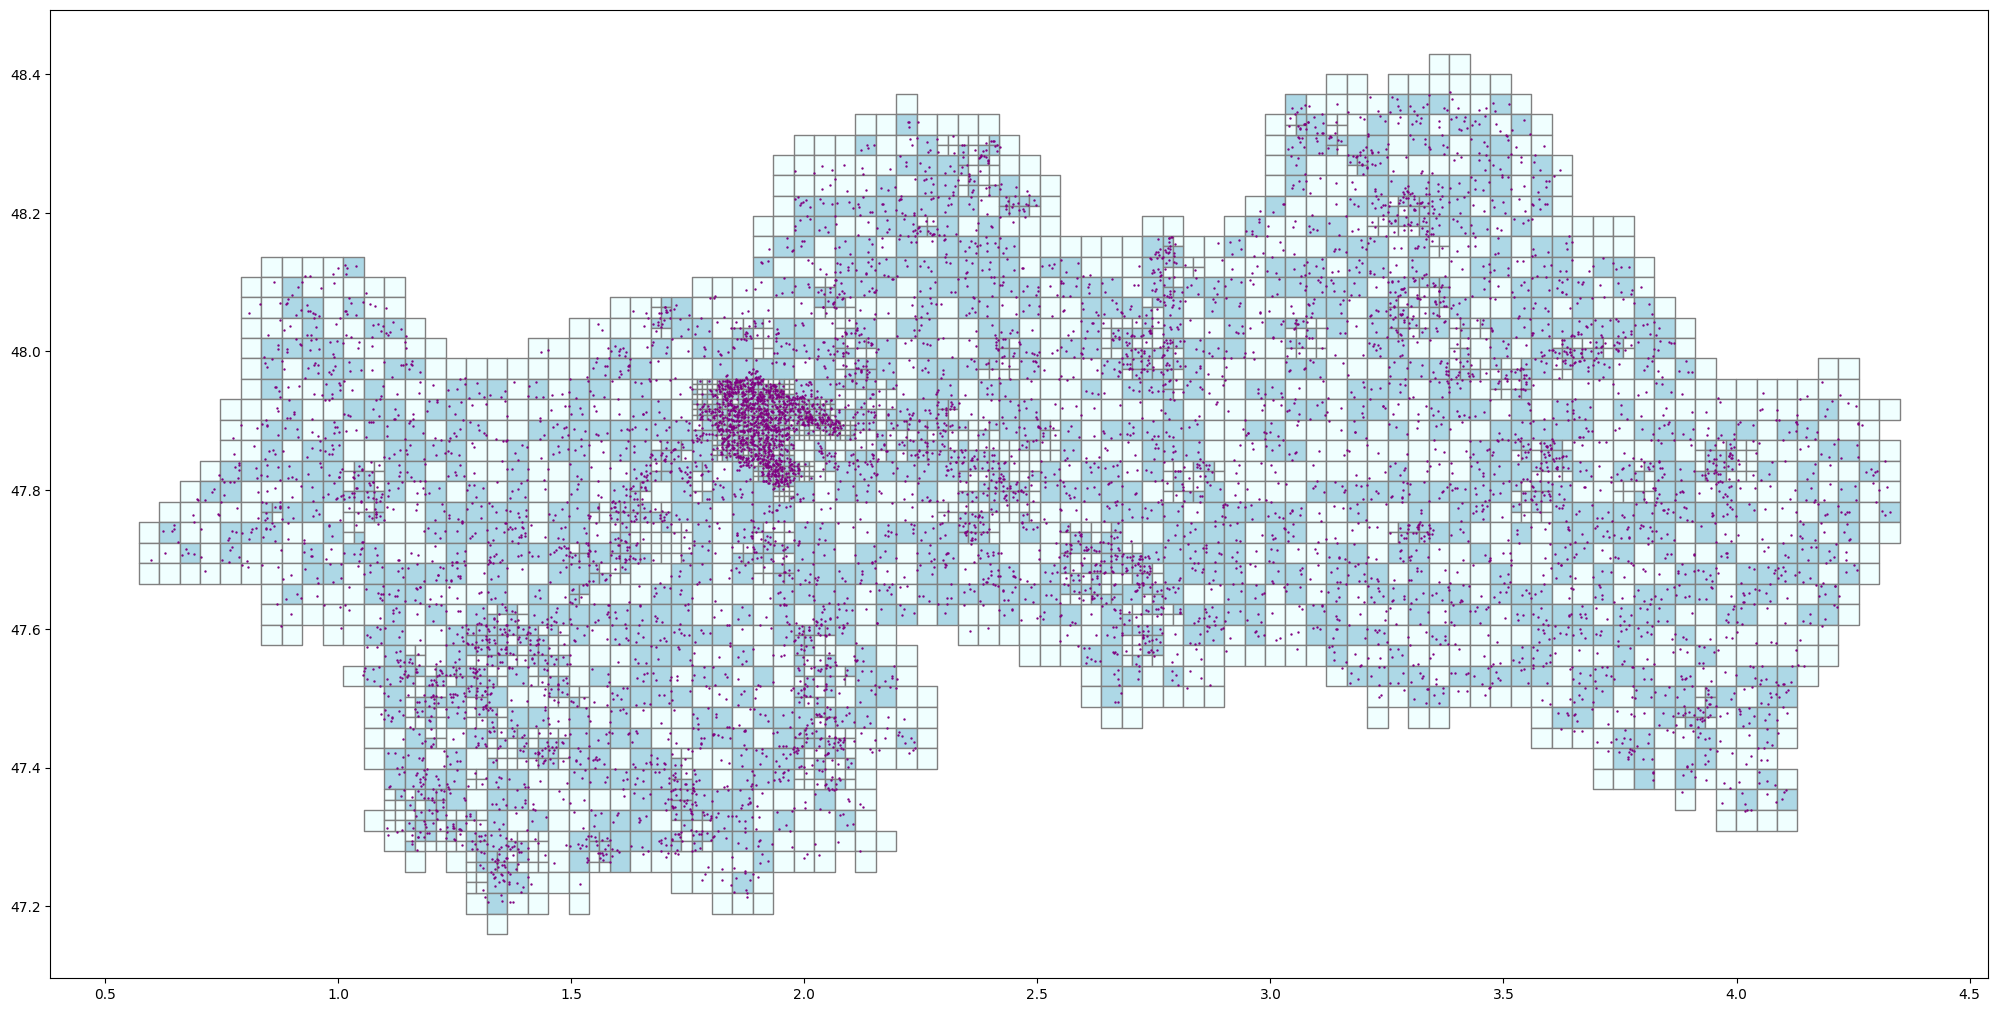

In [509]:
f, ax = plt.subplots(figsize=(25, 25))
tiles_with_counts.plot(
    ax=ax,
    edgecolor="grey",
    figsize=(25, 25),
    facecolor=tiles_with_counts[f"use_{count_col_name}"].map(get_colormap),
    linewidth=tiles_with_counts[f"use_{count_col_name}"].map(get_linewidth_map),
)
gdf_measurements_4g.plot(ax=ax, markersize=0.5, color="purple")

In [510]:
count_col_name = "5g_measurements"
tiles_with_counts = add_measurements_count(
    tiles_with_counts,
    gdf_measurements_5g,
    id_column="tile_id",
    point_count_name=count_col_name,
    threshold_use=MIN_THRESHOLD_5G,
)
tiles_with_counts.shape

(3423, 15)

<Axes: >

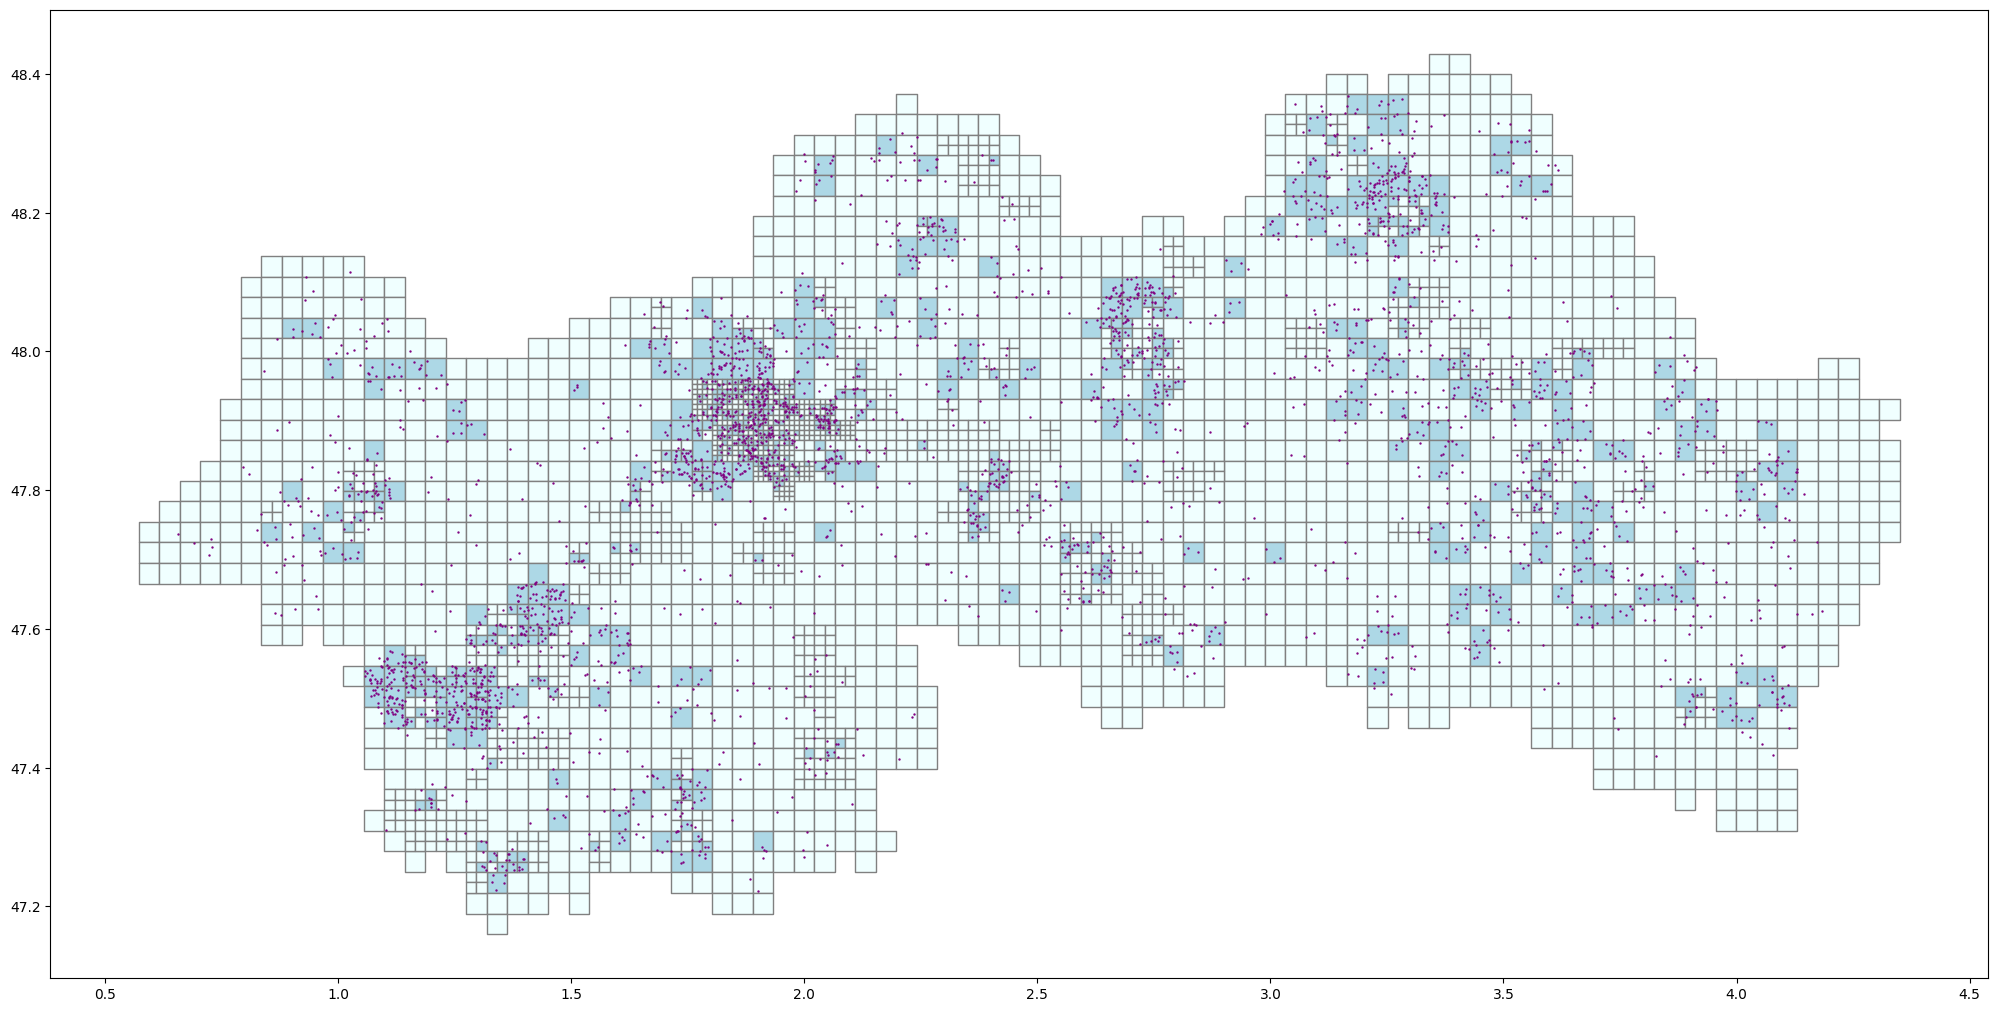

In [511]:
f, ax = plt.subplots(figsize=(25, 25))
tiles_with_counts.plot(
    ax=ax,
    edgecolor="grey",
    figsize=(25, 25),
    facecolor=tiles_with_counts[f"use_{count_col_name}"].map(get_colormap),
    linewidth=tiles_with_counts[f"use_{count_col_name}"].map(get_linewidth_map),
)
gdf_measurements_5g.plot(ax=ax, markersize=0.5, color="purple")

In [513]:
tiles_with_counts.columns

Index(['tile_id', 'geometry', 'type', 'total_measurements',
       'meandbm_total_measurements', 'operators_total_measurements',
       'use_total_measurements', '4g_measurements', 'meandbm_4g_measurements',
       'operators_4g_measurements', 'use_4g_measurements', '5g_measurements',
       'meandbm_5g_measurements', 'operators_5g_measurements',
       'use_5g_measurements'],
      dtype='object')

## Networks

/tmp/ipykernel_863899/2080184528.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.column_stack((filetered_network.centroid.x, filetered_network.centroid.y))
/tmp/ipykernel_863899/2080184528.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Queen.from_dataframe(filetered_network)
/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 218, 1743.
  W.__init__(self, neighbors, ids=ids, **kw)


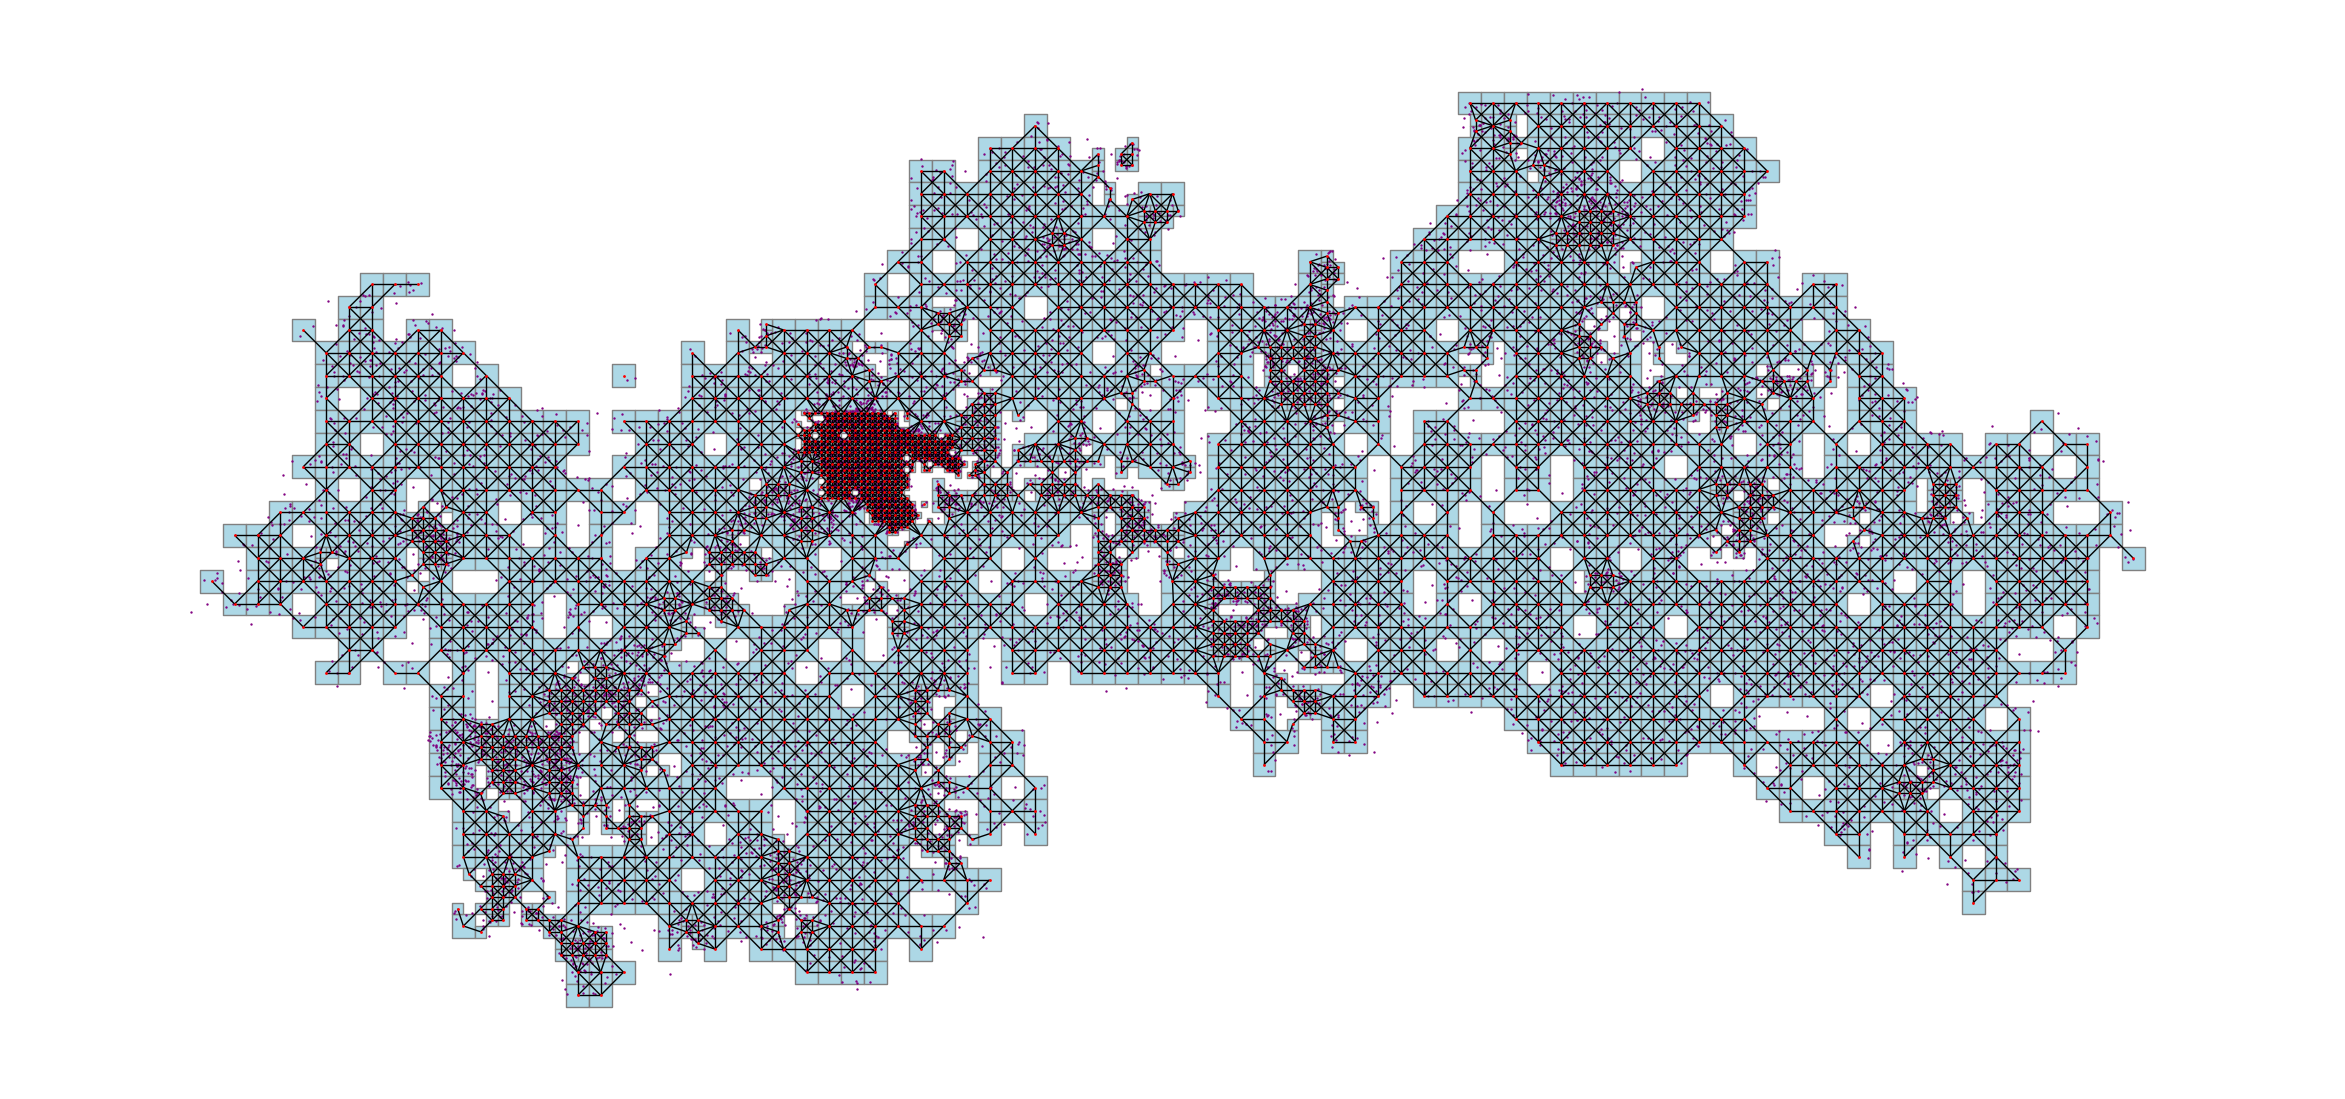

In [519]:
filetered_network = tiles_with_counts[tiles_with_counts['use_total_measurements']]

centroids = np.column_stack((filetered_network.centroid.x, filetered_network.centroid.y))
queen = weights.Queen.from_dataframe(filetered_network)
graph = queen.to_networkx()
positions = dict(zip(graph.nodes, centroids))
# plot with a nice basemap
ax = filetered_network.plot(
    linewidth=1, edgecolor="grey", figsize=(30, 30), facecolor="lightblue"
)
gdf_measurements_all.plot(ax=ax, markersize=0.5, color="purple")
nx.draw(graph, positions, ax=ax, node_size=1, node_color="r")
plt.show()